# Exercise 2

Work on this before the next lecture on 24 April. We will talk about questions, comments, and solutions during the exercise after the third lecture.

Please do form study groups! When you do, make sure you can explain everything in your own words, do not simply copy&paste from others.

The solutions to a lot of these problems can probably be found with Google. Please don't. You will not learn a lot by copy&pasting from the internet.

If you want to get credit/examination on this course please upload your work to **your GitHub repository** for this course **before** the next lecture starts and post a link to your repository [in this thread](https://github.com/wildtreetech/advanced-comp-2017/issues/3). If you worked on things together with others please add their names to the notebook so we can see who formed groups.

---

These are some useful default imports for plotting and [`numpy`](http://www.numpy.org/)

In [48]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
from sklearn.utils import check_random_state

## Question 1

Correlation between trees. This question is about investigating the correlation between decision trees and how this effects an ensemble constructed from them. There are three methods
for adding randomisation to the tree growing process:

1. grow each tree on a bootstrap sample
2. for each tree select a subset of features at random
3. pick the best random split point

You can use `RandomForestClassifier`, `BaggingClassifier`, and `ExtraTreesClassifier` to achieve various different sets of the above three strategies.

Show how the average amount of correlation between the trees in the ensemble varies as a function of bootstrap yes/no, number of `max_features`, and picking the best split point at random or not.

Pick one of the classification datasets from http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets.

<function __main__.plot_correlation>

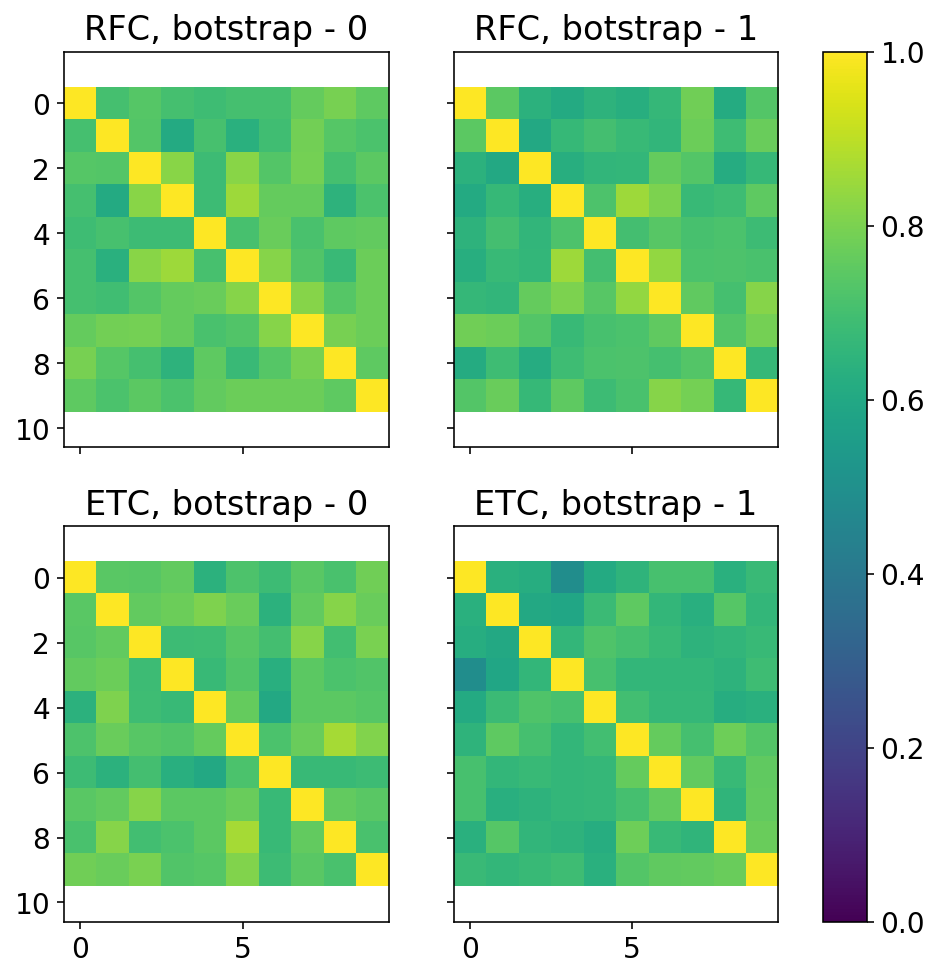

In [49]:
# your solution
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats.stats import pearsonr
from ipywidgets import interact


# loading data on breast cancer
data = load_breast_cancer()
data_dimensionality = len(data.feature_names)
X, y = data.data, data.target
# split for train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)
# classifiers
n_estimators = 10
rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=None, random_state=42)
bc = BaggingClassifier(DecisionTreeClassifier(), n_estimators=n_estimators, random_state=42)
etc = ExtraTreesClassifier(n_estimators=n_estimators, max_depth=None, random_state=42)

#clfs = [(rfc, 'RFC'), (bc, 'BC'), (etc, 'ETC')]
clfs = [(rfc, 'RFC'), (etc, 'ETC')]
max_features = np.arange(1, data_dimensionality+1)
#max_features = np.arange(2, 8)
# vary the bootstrap=True/False and the number of features
# !!! I couldn't figure out why my approach works for RFC and ETC, but doesn't work for BaggingClasssfier :(
correlations = []
for clf, clf_name in clfs:
    corr_bootstrap = []
    for decision in [False, True]:
        corr_features = []
        for max_feature in max_features:
            clf.set_params(max_features=max_feature, bootstrap=decision)
            clf.fit(X_train, y_train)
            correlation = np.zeros((n_estimators, n_estimators))
            for i in range(n_estimators):
                for j in range(n_estimators):
                    clf1 = clf.estimators_[i]
                    clf2 = clf.estimators_[j]
                    correlation[i,j] = np.corrcoef(clf1.predict_proba(X_test)[:,0], clf2.predict_proba(X_test)[:,0])[0, 1]
            corr_features.append(correlation)
        corr_bootstrap.append(corr_features)
    correlations.append(corr_bootstrap)

def plot_correlation(my_max_features = 5):
    fig, axes = plt.subplots(len(clfs), 2, sharex=True, sharey=True)
    my_max_features = 5
    for i, axx in enumerate(axes):
        for j, ax in enumerate(axx):
            ind = list(max_features).index(my_max_features)
            im = ax.imshow(correlations[i][j][ind], interpolation='none', vmin=0, vmax=1)
            title = clfs[i][1]+', botstrap - '+str(j)
            ax.set_title(title)
    fig.colorbar(im, ax=axes.ravel().tolist())
    
interact(plot_correlation, my_max_features=(np.min(max_features), np.max(max_features)))

---

## Question 2

Compare the feature importances calculated by a `RandomForestClassifier`, `ExtraTreesClassifier` and `GradientBoostedTreesClassifier` on the digits dataset. You might have to tune `n_estimators` to get good performance. Which parts of the images is the most important and do you agree with the interpretation of the classifiers? (Bonus) Do the importances change if you change to problem to be a classification problem of odd vs even digit?

You can load the data set with: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits

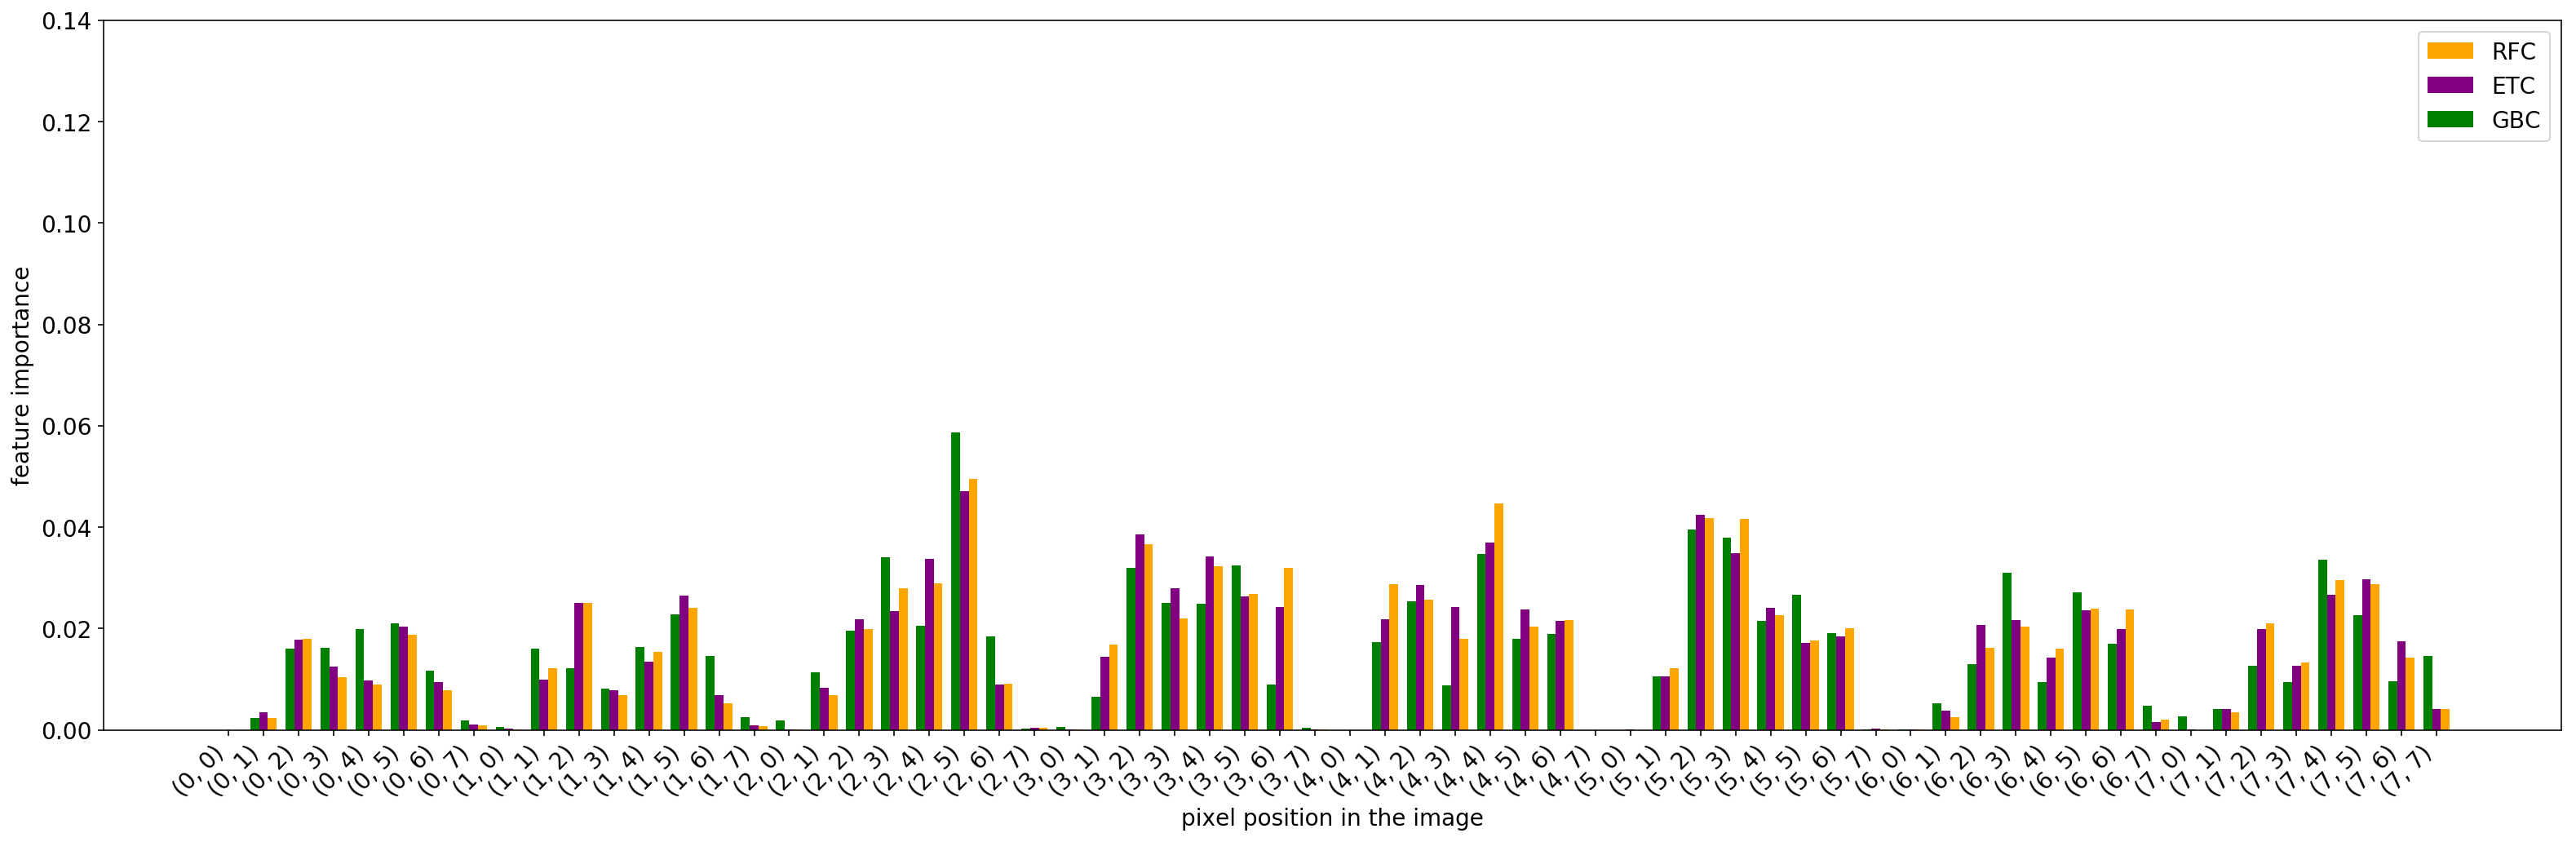

In [52]:
# your answer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_digits
import itertools
plt.rcParams["figure.figsize"] = (27, 8)

# loading data on breast cancer
data = load_digits()
X, y = data.data, data.target

# split for train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)
# classifiers
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
etc = ExtraTreesClassifier(n_estimators=100, random_state=42)
gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
# train classifiers
clfs = [(rfc, 'RFC'), (etc, 'ETC'), (gbc, 'GBC')]
for clf, clf_name in clfs:
    clf.fit(X_train, y_train)    
# plot
index = np.arange(np.shape(X)[1])
bar_width = 0.25
plt.bar(index+bar_width, rfc.feature_importances_, bar_width, label='RFC', color='orange')
plt.bar(index, etc.feature_importances_, bar_width, label='ETC', color='purple')
plt.bar(index-bar_width, gbc.feature_importances_, bar_width, label='GBC', color='green')

plt.legend(loc='best')
plt.xlabel('pixel position in the image')
plt.ylabel('feature importance')
plt.ylim([0, 0.14])
index_label = itertools.product(np.arange(8), np.arange(8))
index_label = list(map(str, list(index_label)))
plt.xticks(index, index_label, rotation=45, horizontalalignment="right");


We can see that left and right borders of images are not immportant, while middle part is important. Also, middle lines are more important that top and bottom lines. I do agree with this, as cornes and borders do carry little information about the digits.

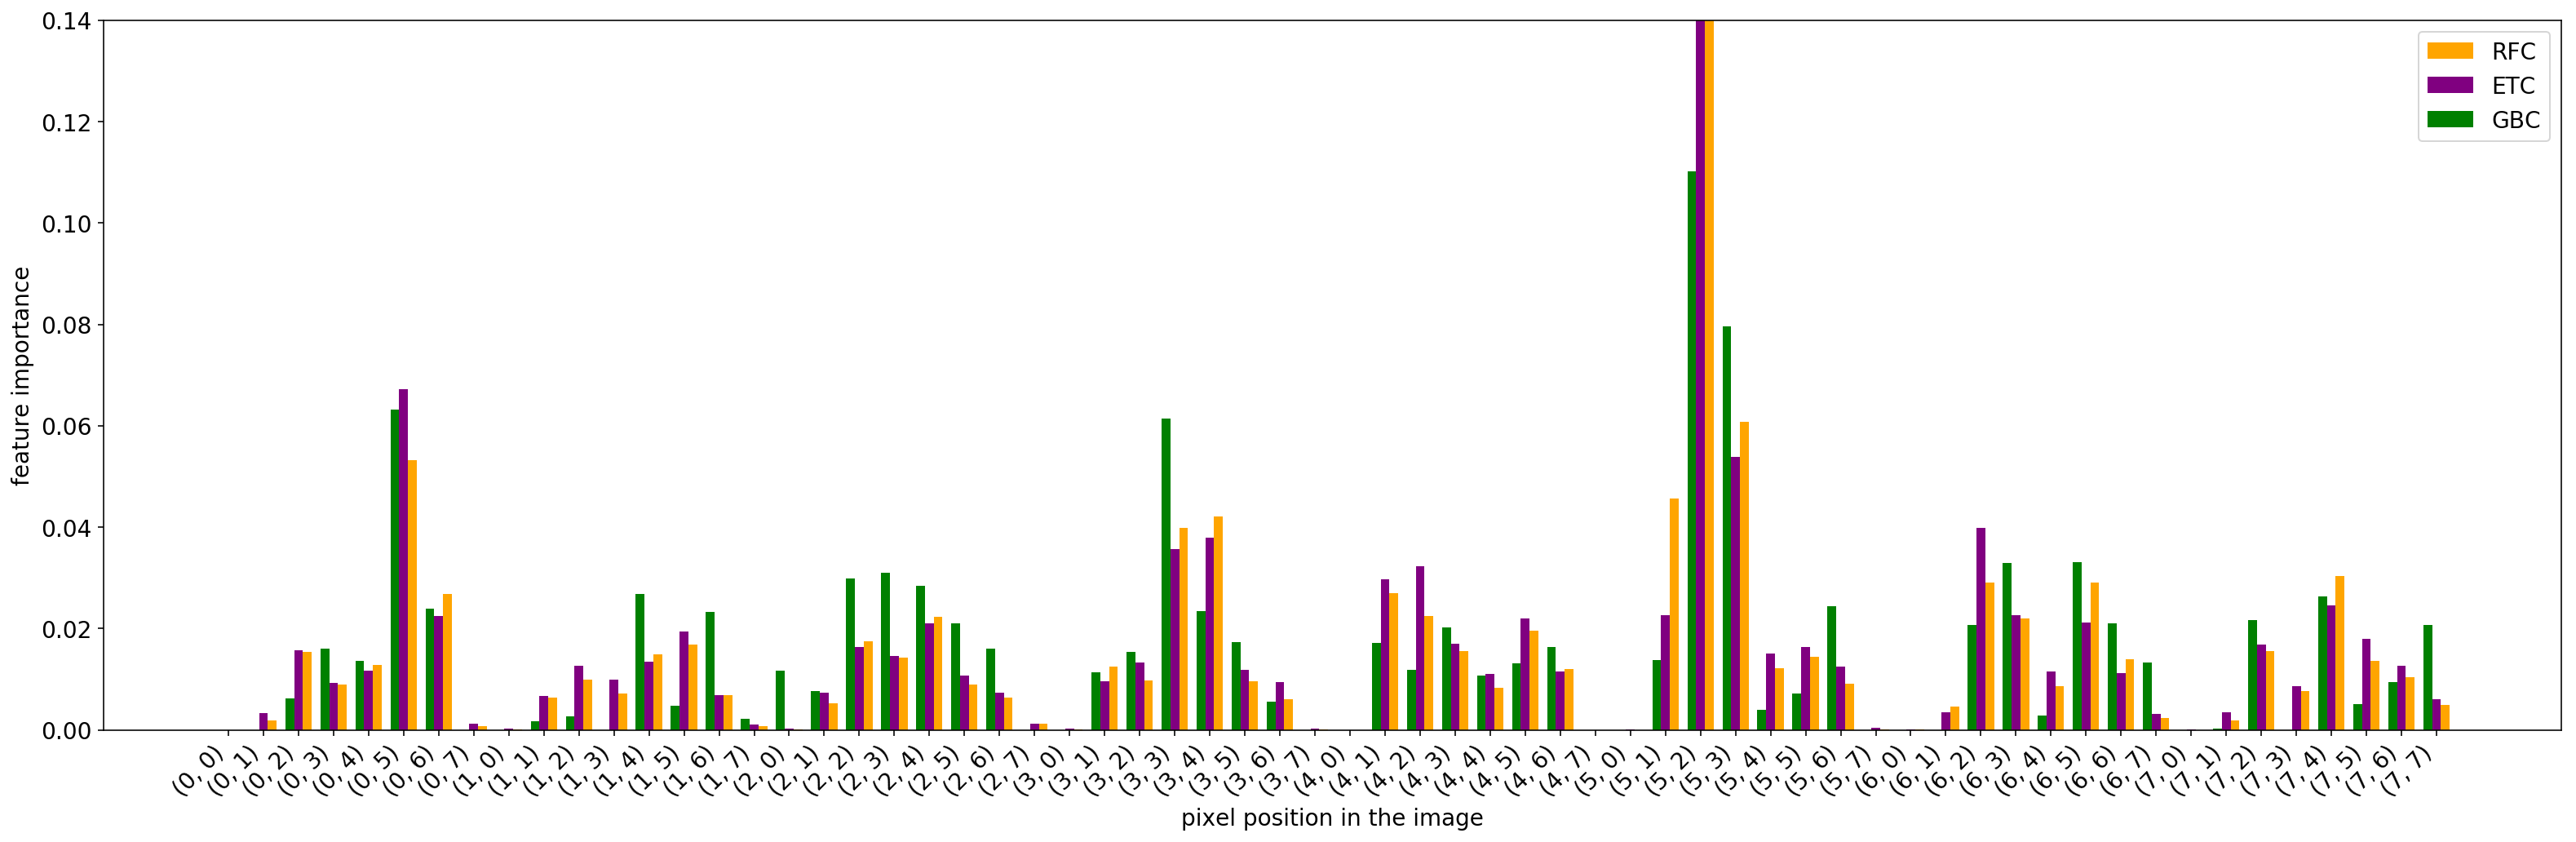

In [51]:
# Now let's change the problem to be a classification of odd vs even digit
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_digits
import itertools
plt.rcParams["figure.figsize"] = (27, 8)

# loading data on breast cancer
data = load_digits()
X, y = data.data, data.target
# change the signification of targets
y = np.array([0 if yy%2==0 else 1 for yy in y])

# split for train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)
# classifiers
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
etc = ExtraTreesClassifier(n_estimators=100, random_state=42)
gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
# train classifiers
clfs = [(rfc, 'RFC'), (etc, 'ETC'), (gbc, 'GBC')]
for clf, clf_name in clfs:
    clf.fit(X_train, y_train)    
# plot
index = np.arange(np.shape(X)[1])
bar_width = 0.25
plt.bar(index+bar_width, rfc.feature_importances_, bar_width, label='RFC', color='orange')
plt.bar(index, etc.feature_importances_, bar_width, label='ETC', color='purple')
plt.bar(index-bar_width, gbc.feature_importances_, bar_width, label='GBC', color='green')

plt.legend(loc='best')
plt.xlabel('pixel position in the image')
plt.ylabel('feature importance')
plt.ylim([0, 0.14])
index_label = itertools.product(np.arange(8), np.arange(8))
index_label = list(map(str, list(index_label)))
plt.xticks(index, index_label, rotation=45, horizontalalignment="right");

The importance does change, though not that much. Manely, the 6th line gets to be very important. I guess it comes form the fact that if you look at images you migh notice, that there are more empty pixels in the middle of that line for even digits that for odd ones. 

---

## Question 3

This is a regression problem. Use a gradient boosted tree regressor (tune the `max_depth`, `learning_rate` and `n_estimators` parameters) to study the importance of the different features as well as the partial dependence of the output on individual features as well as pairs of features.

* can you identify uninformative features?
* how do the interactions between the features show up in the partial dependence plots?

(Help: `rgr = GradientBoostingRegressor(n_estimators=200, max_depth=2, learning_rate=0.1)
` seems to work quite well)
(Help: to produce 1D and 2D partial dependence plots pass `[0,1, (0,1)]` as the `features` argument of `plot_partial_dependence`. More details in the function's documentation.)


In [53]:
from sklearn.ensemble import GradientBoostingRegressor


def make_data(n_samples=800, n_features=8, noise=0.2, random_state=2):
    generator = check_random_state(random_state)

    X = generator.rand(n_samples, n_features)
    y = 10 * (X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 \
        + 10 * X[:, 3] + 10 * X[:, 4] + noise * generator.randn(n_samples)

    return X, y

X,y = make_data()

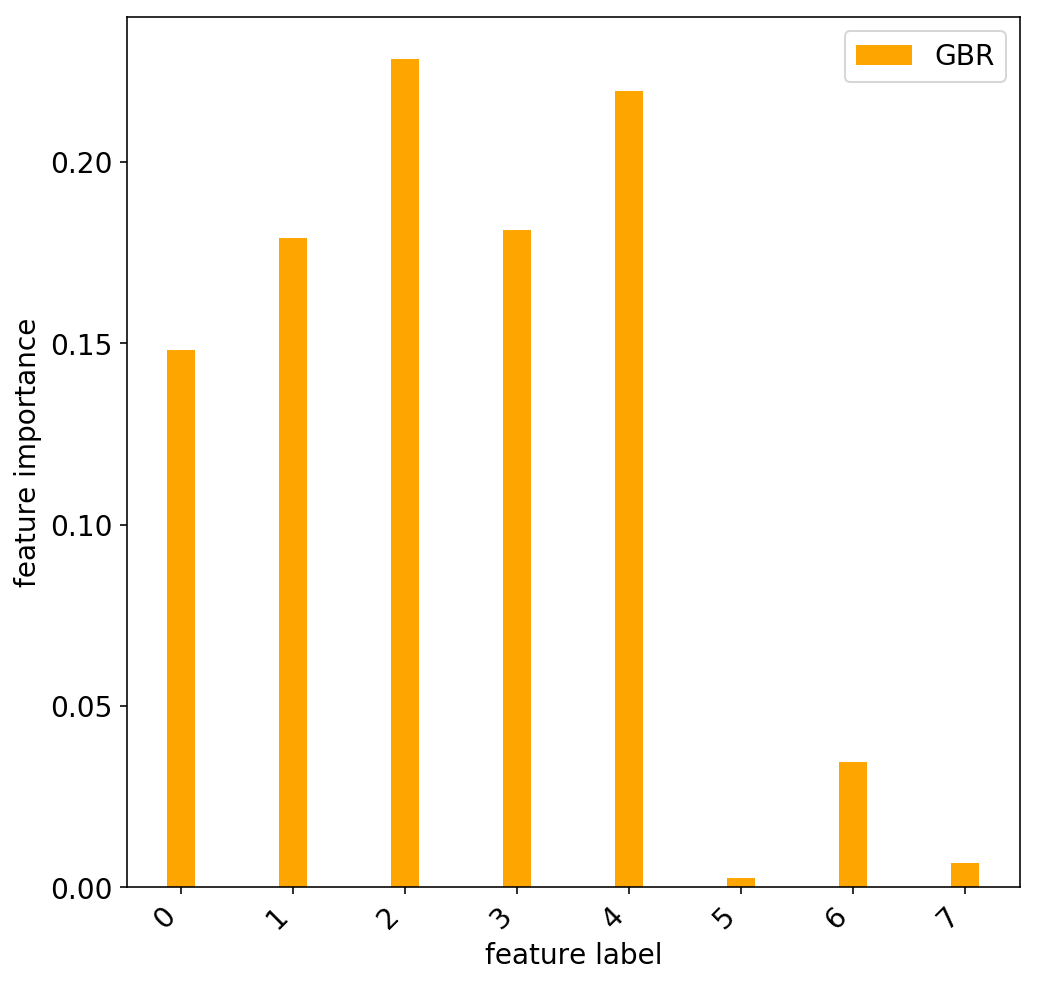

In [54]:
# your solution
plt.rcParams["figure.figsize"] = (8, 8)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)
gbr = GradientBoostingRegressor(n_estimators=200, max_depth=2, learning_rate=0.1)
gbr.fit(X_train, y_train)

index = np.arange(8)
bar_width = 0.25
plt.bar(index, gbr.feature_importances_, bar_width, label='GBR', color='orange')

plt.legend(loc='best')
plt.xlabel('feature label')
plt.ylabel('feature importance')
feature_names = np.arange(8)
plt.xticks(index, feature_names, rotation=45, horizontalalignment="right");



The uninformative features seem to be #5, #6 and #7. And indeed, they are not used in the data generating code.

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]


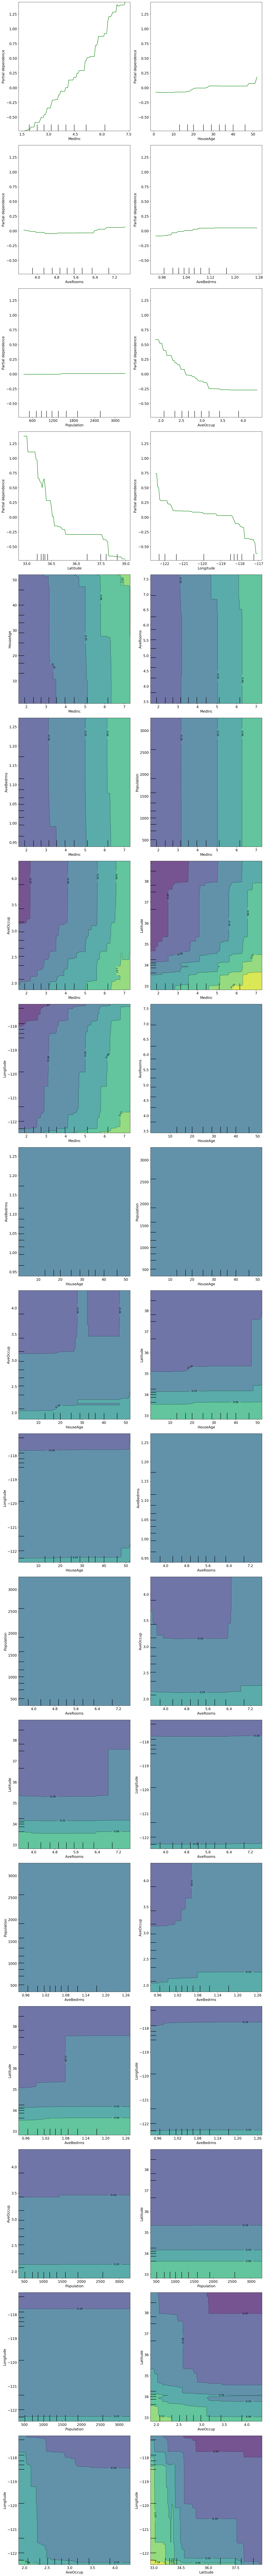

In [62]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import itertools
combination = list(itertools.combinations(index, 2))
print(combination)
plot_partial_dependence(gbr, X, features=[0, 1, 2, 3, 4, 5, 6, 7, (0, 1), (0, 2), (0, 3), (0, 4), \
                                          (0, 5), (0, 6), (0, 7), (1, 2), (1, 3), (1, 4), (1, 5), \
                                          (1, 6), (1, 7), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), \
                                          (3, 4), (3, 5), (3, 6), (3, 7), (4, 5), (4, 6), (4, 7), \
                                          (5, 6), (5, 7), (6, 7)], feature_names=feature_names,
                        figsize=(15,8*18), n_cols=2);
plt.tight_layout();

This can be seen even better from the partial dependence plots. The (5,6), (5,7) and (6,7) don't show any dependance. The partial dependance plots with only dependance on either 5, 6 or 7 show a constant line meaning no dependance either. Other features do show certain tendencies in their plots.

---

## (Bonus) Question 4

House prices in California. Use a gradient boosted regression tree model to build a model that can predict house prices in California (`GradientBoostingRegressor` is your friend).

Plot each of the features as a scatter plot with the target to learn about each variable. You can also make a plot of two features and use the target as colour.

Fit a model and tune the model complexity using a training and test data set.

Explore the feature importances and partial dependences that are important to the house price.

In [56]:
from sklearn.datasets.california_housing import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor

cal_housing = fetch_california_housing()

# if the above doesn't work, download `cal_housing_py3.pkl` from the GitHub repository
# and adjust the path to the downloaded file which is passed to `load()`
# uncomment the following lines
#from sklearn.externals.joblib import load
#d = load('/home/username/Downloads/cal_housing_py3.pkz')
#X, y = d[:,1:], d[:,0]/100000
#X[:, 2] /= X[:, 5]
#X[:, 3] /= X[:, 5]
#X[:, 5] = X[:, 4] / X[:, 5]

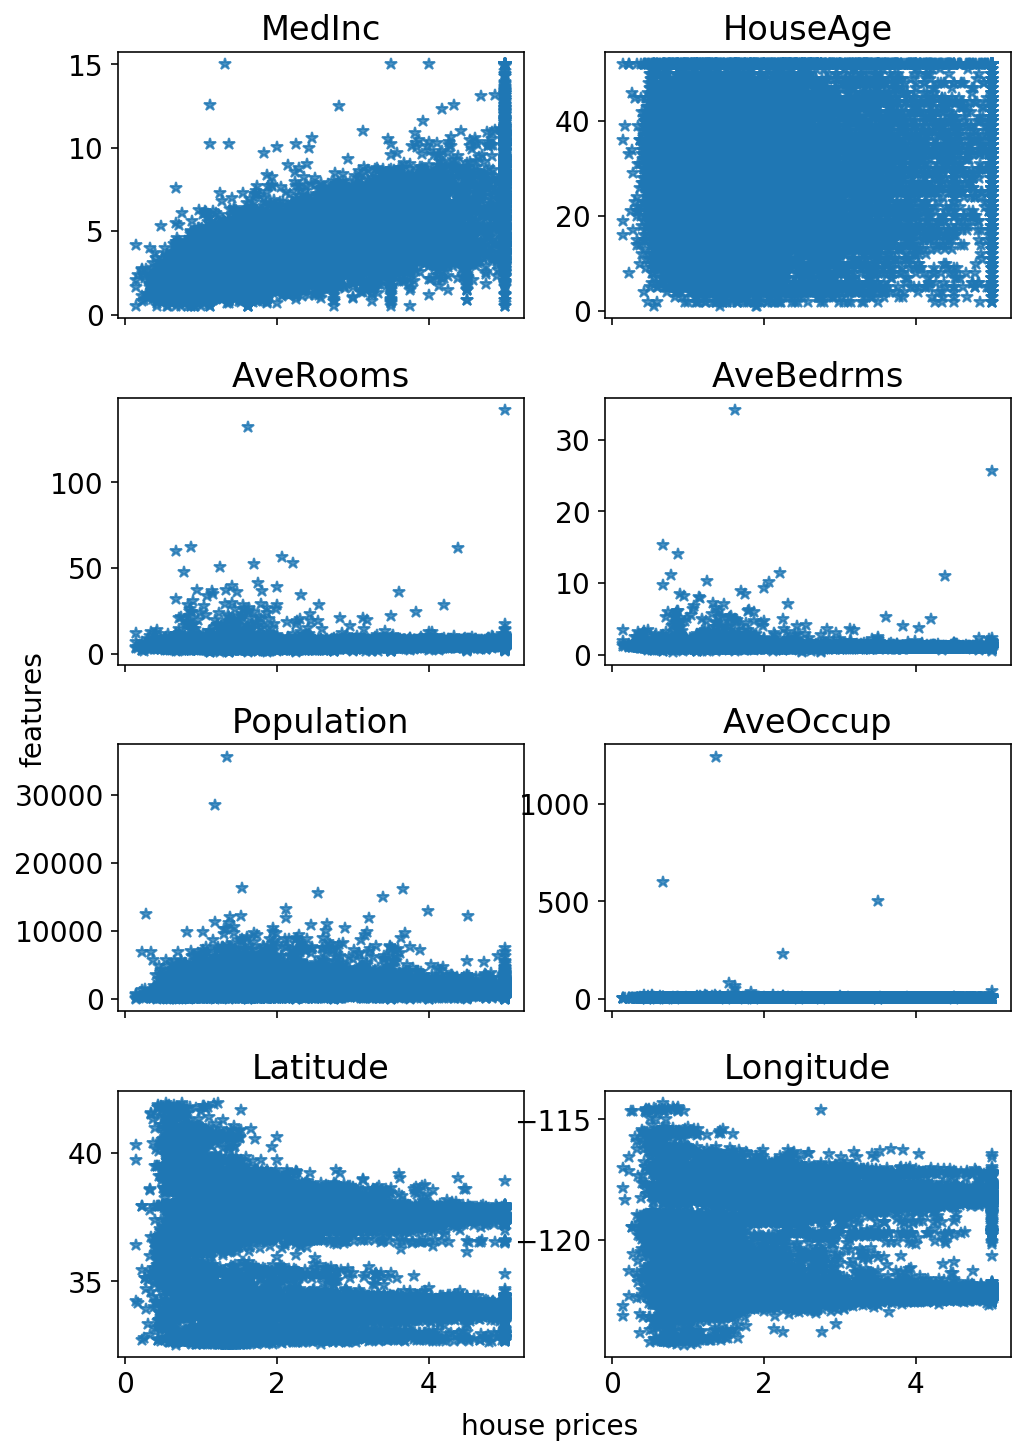

In [57]:
# your solution
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.datasets.california_housing import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from utils import plot_loss
plt.rcParams["figure.figsize"] = (8, 12)

cal_housing = fetch_california_housing()

X, y = cal_housing.data, cal_housing.target
feature_names = cal_housing.feature_names

fig, axes = plt.subplots(int(len(feature_names)/2), 2, sharex=True)
for ind, ax in enumerate(axes.flatten()):
    # to color with density
    #x_ = y
    #y_ = X[:,ind]
    #xy = np.vstack([x_,y_])
    #z_ = gaussian_kde(xy)(xy)
    #ax.scatter(x_, y_, c=z_, s=100, edgecolor='')
    ax.plot(y, X[:,ind], '*', alpha=0.8)
    ax.set_title(feature_names[ind])
fig.subplots_adjust(hspace=0.3)
fig.text(0.5, 0.08, 'house prices', ha='center')
fig.text(0.04, 0.5, 'features', va='center', rotation='vertical')


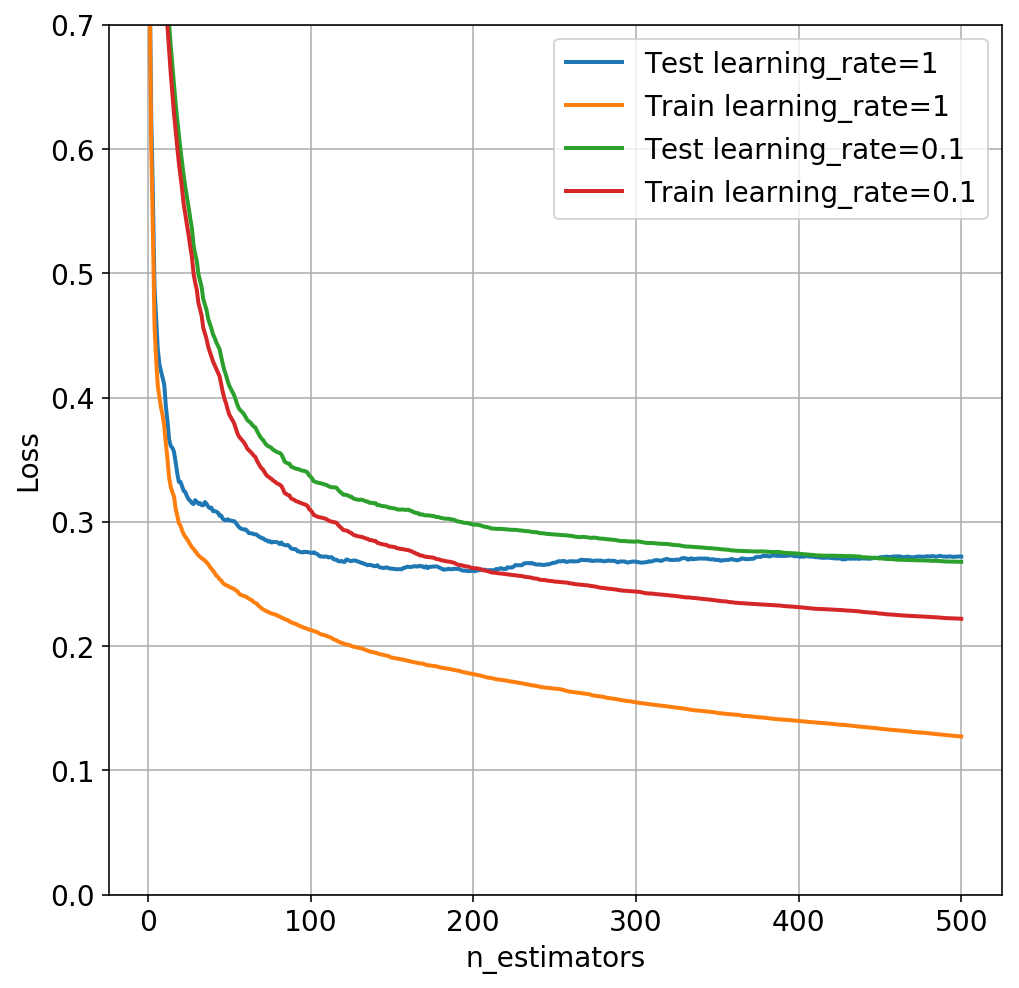

In [58]:
plt.rcParams["figure.figsize"] = (8, 8)
# test the param tunning of regressor
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

ax = plt.gca()
gbr = GradientBoostingRegressor(n_estimators=500, max_depth=2, learning_rate=1.)
gbr.fit(X_train, y_train)
_, ax = plot_loss(gbr, X_test, y_test, ax=ax, label='learning_rate=1')

gbr = GradientBoostingRegressor(n_estimators=500, max_depth=2, learning_rate=0.1)
gbr.fit(X_train, y_train)
_, ax = plot_loss(gbr, X_test, y_test, ax=ax, label='learning_rate=0.1')
ax.legend(loc='best')
ax.grid()


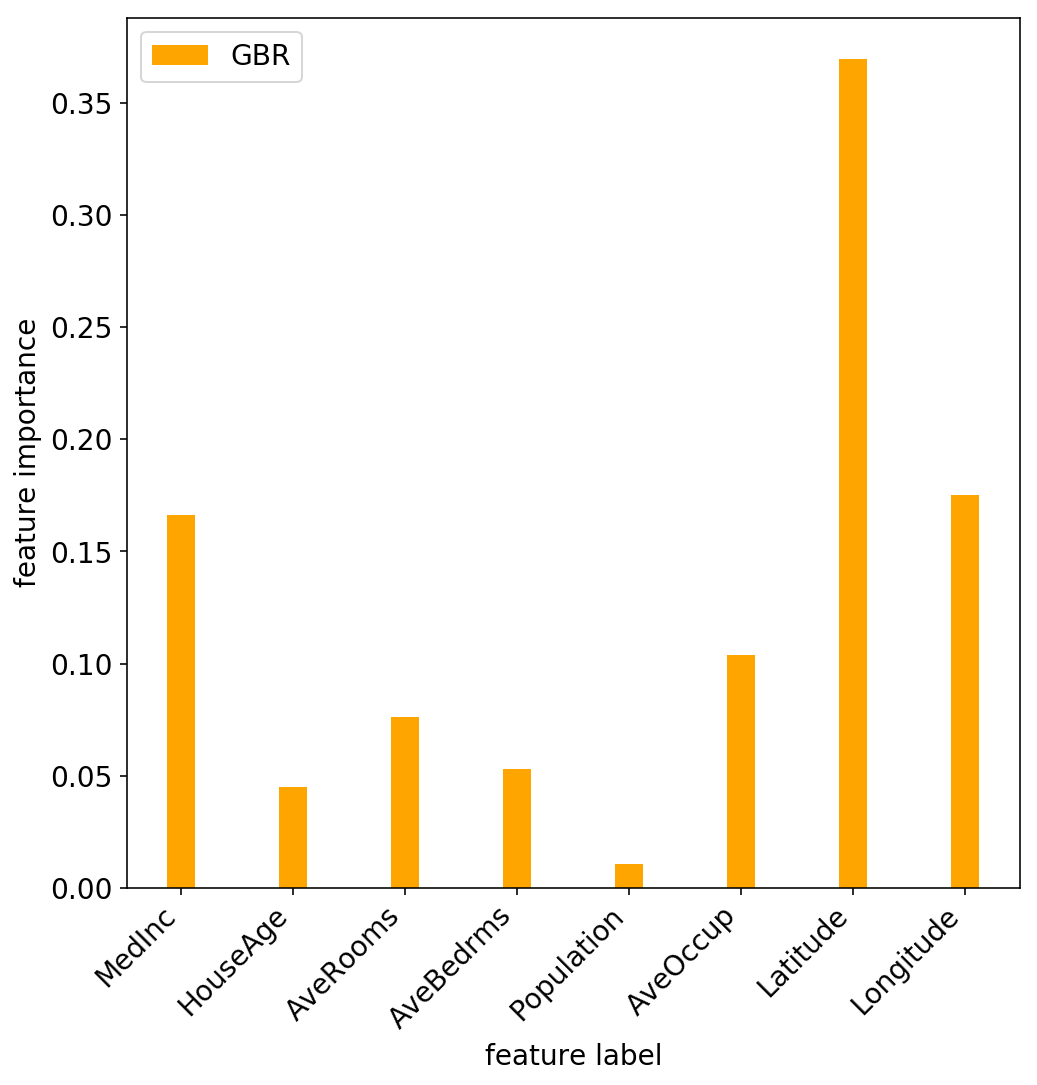

In [59]:
# with chosen best params
gbr = GradientBoostingRegressor(n_estimators=150, max_depth=2, learning_rate=0.1)
gbr.fit(X_train, y_train)

index = np.arange(len(feature_names))
bar_width = 0.25
plt.bar(index, gbr.feature_importances_, bar_width, label='GBR', color='orange')

plt.legend(loc='best')
plt.xlabel('feature label')
plt.ylabel('feature importance')
plt.xticks(index, feature_names, rotation=45, horizontalalignment="right");

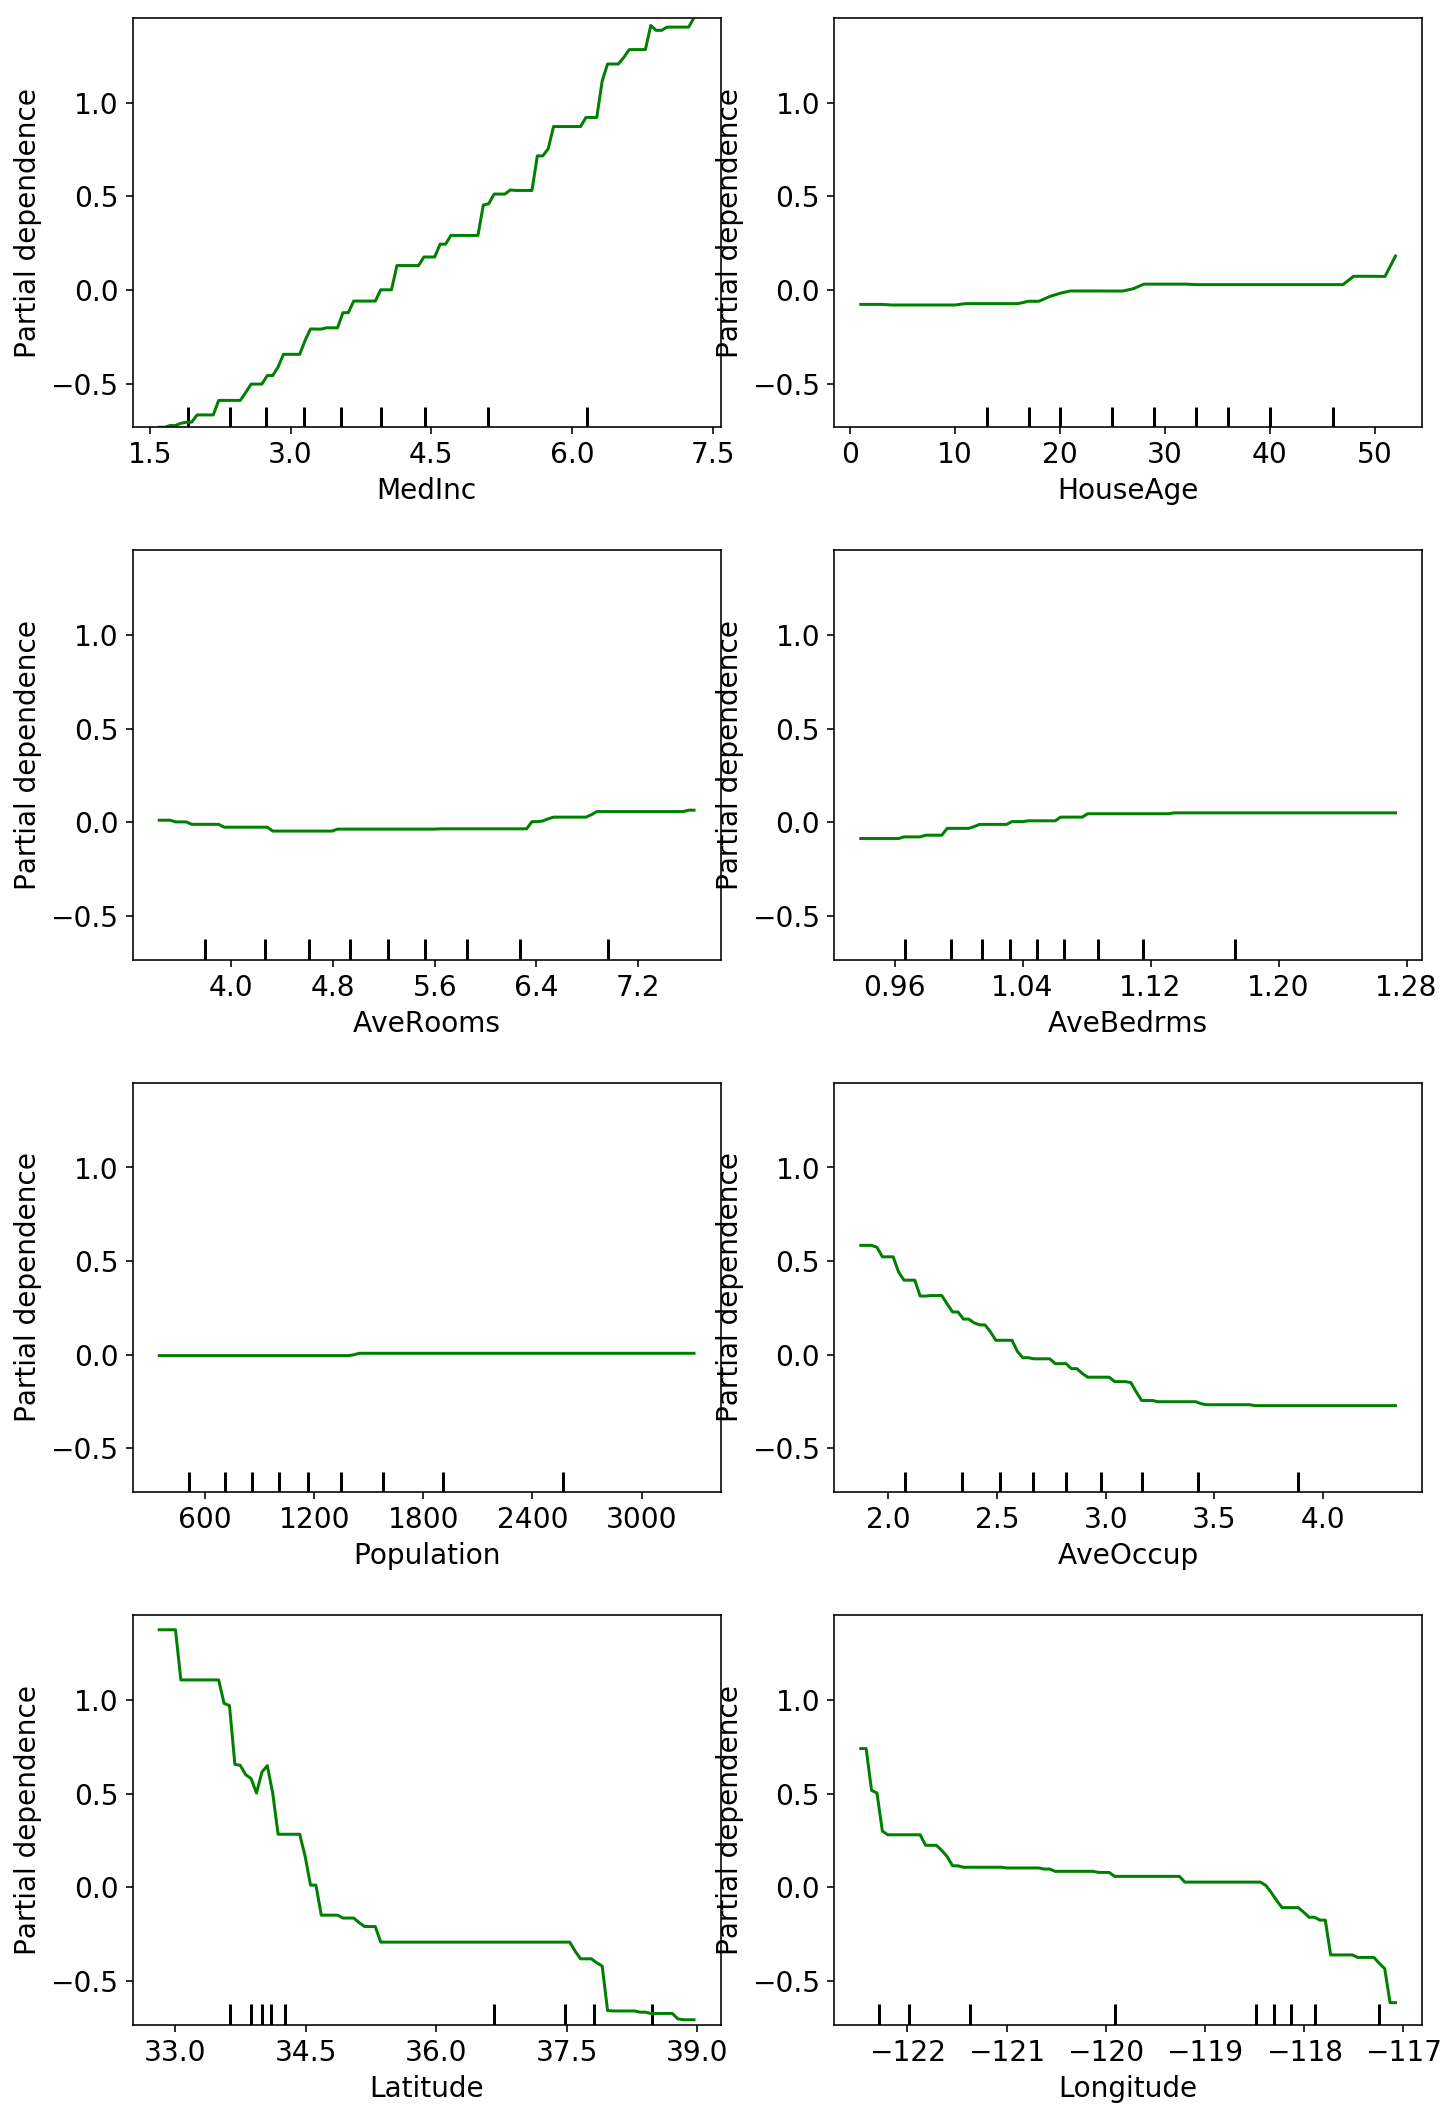

In [60]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
plot_partial_dependence(gbr, X, features=[0, 1, 2, 3, 4, 5, 6, 7], feature_names=feature_names,
                        figsize=(10,15), n_cols=2);
plt.tight_layout();

We can see that HouseAge, AveBedrs, Population are non-important features. AveRooms is marginally important. 